Chris Ventura<br>
Final Project<br>
Exploratory Data Analysis<br>

Goal: <br>
    <BLOCKQUOTE> To determine if a Medicare Advantage Health Plan's Medical Loss Ratio (MLR) can be predicted using publicly available information about the health plan's population (risk score, average monthly payment, county breakdown) and competitive market (market average risk score, market average monthly payment, market average payment rate).</BLOCKQUOTE>

Background: <br>
        <BLOCKQUOTE>MLR is a health plan's total health expenditure divided by a health plan's total premium revenue (there is a bit more that goes into how the numerator and denominator are derived, but I'll skip the details for now). This metric is typically how health plans determine profitability, and even how the government regulates markets (typically plans must spend at least 85% of their premium revenue on health delivery or improvement, or have an MLR of at least 0.85). Typically, health plans would like their MLR to be as close to .85 as possible. <br> <br>
        For my project, I would like to determine the impact of market and population on a health plan's MLR. To do so, I will be using several publicly available files. I will use a plan's product and county membership makeup to aggregate all stats to the plan level. I will then use the plan level data to try to estimate a plan's MLR using linear regression. For the exploratory data analysis, I will try to get the data in working order by performing these aggregations, then visualize and examine possible features for my model, as well as assess any weak points or additional statistics I may want to incorporate.</BLOCKQUOTE>

Section 0 - Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Section 1 - Import Various Datasets for analysis to create master dataset

In [3]:
# 1.1 - Plan Level MLR data (note, this is going to be my hub)
# Note - I heavily edited this in excel to remove unnecessary columns (there were like 200)
df_MLR = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_Plan_MLR.csv")
print df_MLR.head()
# The contract number (commonly referred to as H code) will be how I join all datasets

# 1.2 - Plan Level Risk Score
df_PlanPartCRS = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_Plan_PartC_RS.csv")
print df_PlanPartCRS.head()

# 1.3 - County Level Risk Score
df_CountyPartCRS = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Clean_2014_County_PartC_RS.csv", dtype={'county_code': np.str})
print df_CountyPartCRS.head()

# 1.4 - Contract Info
df_ContractInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Contract_Info_2014_12.csv")
print df_ContractInfo.head()

# 1.5 - County Plan Enrollment Info
df_CountyPlanEnrollmentInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Enrollment_Info_2014_12.csv", dtype={'SSA State County Code': np.str})
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo[df_CountyPlanEnrollmentInfo.Enrollment != '*']
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo[df_CountyPlanEnrollmentInfo['Plan ID'] != 999]
print len(df_CountyPlanEnrollmentInfo)

# 1.6 - Plan Enrollment Info
df_PlanEnrollmentInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/Monthly_Report_By_Plan_2014_12.csv")
print df_PlanEnrollmentInfo.head()

# 1.7 - State/County Penetration Rates
df_countypen = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/State_County_Penetration_MA_2014_12.csv", dtype={'SSA': np.str})
df_countypen['Penetration'].fillna(value=0.00, inplace = True)
print df_countypen.head()

# 1.8 - Plan PBP Detailed Info
df_planPBPInfo = pd.read_csv("/Users/cventura/GitHub/final_project/final_datasets/CPSC_Contract_Info_2014_12.csv")
df_planPBPInfo = df_planPBPInfo.dropna()
print df_planPBPInfo.head()

  contract_number  contract_year  \
0           H0028           2014   
1           H0084           2014   
2           H0104           2014   
3           H0107           2014   
4           H0108           2014   

                                       organization  adjusted_MLR  
0                                      CHA HMO INC.          0.96  
1  CARE IMPROVEMENT PLUS OF TEXAS INSURANCE COMPANY          0.96  
2                 Blue Cross Blue Shield of Alabama          0.92  
3                   Health Care Service Corporation          1.02  
4             HUMANA HEALTH PLAN OF CALIFORNIA INC.          0.99  
  contract_number  plan_benefit_package contract_name plan_type  \
0           H0028                     1  CHA HMO INC.       HMO   
1           H0028                     2  CHA HMO INC.       HMO   
2           H0028                     3  CHA HMO INC.       HMO   
3           H0028                     4  CHA HMO INC.       HMO   
4           H0028                     5 

Couple Notes:
1. As stated above, the MLR table will serve as my hub.  The grain of this dataframe is one record per MCO Contract Number (also referred to as an "H Code" due to the first character of the field).
2. Most of the files are at either a county level or a Plan Benefit Package (PBP) level.  A PBP is a variant of the product offered by the health plan.  One H Code may have multiple PBPs, but each PBP can only have on H Code.  Typically these products are very similar, but may have small differences, such as the type of drug coverage offered.
3. The County Plan Enrollment table contains enrollment in each PBP by county.  I strip out records where the enrollment is a star (less than 10 enrolled, which means they cannot give the exact number due to some weird HIPAA bylaw) or where the PBP number is "999", which is a catch-all for incomplete information.  I will use this table in the coming steps to determine the percent of a plan's enrollment in each PBP and in each county to come up with weighted averages for risk scores, payment rates, etc.

Section 2 - Adjust data to same grain

Note: <br>
A couple of my joins cause some records from the original MLR table to fall out.  This is intentional - I validated that the records that drop are from specific types of plans whose information is not reported in the other files, and are not comparable to the other plans which we are analyzing.

In [4]:
#2.1 - Create PBP and County Tables

#   2.1.1 - Remove Counties with no enrollment and append SNP info
    #Convert Enrollment to Numeric
df_CountyPlanEnrollmentInfo['Enrollment'] = df_CountyPlanEnrollmentInfo['Enrollment'].apply(pd.to_numeric)
    #Convert Plan_ID to Int
df_planPBPInfo['Plan ID'] = df_planPBPInfo['Plan ID'].astype(int)
    #Add additional is_SNP field.  SNPs(Special Needs Plans) attract a different membership
    #and have a different risk score, I will use this when rolling up the values later
df_planPBPInfo['is_SNP'] = df_planPBPInfo['SNP Plan'].apply(lambda x: 1 if x == 'Yes' else 0)
    #Merge PBP info to county enrollment info
df_CountyPlanEnrollmentInfo = df_CountyPlanEnrollmentInfo.merge(df_planPBPInfo, how= 'left', left_on = ['Contract Number', 'Plan ID'], right_on= ['Contract ID', 'Plan ID'])
    #Calculate SNP-only enrollment
df_CountyPlanEnrollmentInfo['snp_enrollment'] = df_CountyPlanEnrollmentInfo['is_SNP'] * df_CountyPlanEnrollmentInfo['Enrollment']

#   2.1.2 - Count total enrollment by HCode
df_PlanEnrollmentTotal = df_CountyPlanEnrollmentInfo.groupby('Contract Number')['Enrollment'].sum(
        ).reset_index().rename(columns ={'Enrollment': 'total_enrollment'})

#   2.1.3 - Count total enrollment by HCode/PBP and create PBP % of total ratio
df_planPBPTotals = df_CountyPlanEnrollmentInfo.groupby(['Contract Number', 'Plan ID'])['Enrollment'].sum(
        ).reset_index().rename(columns ={'Enrollment': 'pbp_enrollment'})

df_planPBPTotals = df_planPBPTotals.merge(df_PlanEnrollmentTotal, left_on= 'Contract Number', right_on= 'Contract Number')
    #Create pct ratio of each PBP to plan total - for plan level roll up
df_planPBPTotals['PBP_pct_total'] = df_planPBPTotals['pbp_enrollment'] / df_planPBPTotals['total_enrollment']

#   2.1.4 - Count total enrollment by HCode/county and create county % of total ratio
df_plancountyTotals = df_CountyPlanEnrollmentInfo.groupby(['Contract Number', 'SSA State County Code'])[['Enrollment', 'snp_enrollment']].sum(
        ).reset_index().rename(columns ={'Enrollment': 'county_enrollment', 'SSA State County Code': 'county_code', 'snp_enrollment': 'county_snp_enrollment'})

df_plancountyTotals = df_plancountyTotals.merge(df_PlanEnrollmentTotal, left_on= 'Contract Number', right_on= 'Contract Number')
    #Create county totals and snp percentages
df_plancountyTotals['county_pct_total'] = df_plancountyTotals['county_enrollment'] / df_plancountyTotals['total_enrollment']
df_plancountyTotals['county_snp_pct'] = df_plancountyTotals['county_snp_enrollment'] / df_plancountyTotals['county_enrollment']

#2.2 - Aggregate data to plan level using county/pbp pcts

#   2.2.1 Generate Plan level Risk Scores/Avg Payment and attach to hub
df_planRS_merge = df_PlanPartCRS.merge(df_planPBPTotals, left_on= ['contract_number', 'plan_benefit_package'],\
                                 right_on= ['Contract Number', 'Plan ID'])
    #Multiply risk score and average payments by PBP percentages
df_planRS_merge['RSxPct'] = df_planRS_merge['part_C_risk_score'] * df_planRS_merge['PBP_pct_total']
df_planRS_merge['AvgCPymtxPct'] = df_planRS_merge['average_C_payment'] * df_planRS_merge['PBP_pct_total']
    #Roll up values from previous step to creat plan-level risk score and payment
df_planRS_contract = df_planRS_merge.groupby(['contract_number', 'plan_type'])['RSxPct', 'AvgCPymtxPct', 'total_enrollment'].sum(
        ).reset_index().rename(columns ={'RSxPct': 'risk_score', 'AvgCPymtxPct': 'avg_payment'})
    #Attach plan level values to MLR df
df_MLR = df_MLR.merge(df_planRS_contract, left_on= ['contract_number'], right_on= ['contract_number'])

#   2.2.2 Use county level data to create "market" numbers and attach to hub
    #Risk scores for SNP plans (see step 2.1.1) are listed separately in the county file
    #I separate out the SNP risk scores into a separate colup so that I can weight the risk scores
    #by a plan's SNP percentage in a future step
df_CountyPartCRS['is_SNP'] = df_CountyPartCRS['snp_plan_type'].apply(lambda x: 1 if pd.notnull(x) == True else 0)
df_CountyPartCRS['rs_nonSNP'] = (1 - df_CountyPartCRS['is_SNP']) * df_CountyPartCRS['part_C_risk_score']
df_CountyPartCRS['rs_SNP'] = df_CountyPartCRS['is_SNP'] * df_CountyPartCRS['part_C_risk_score']
df_CountyPartCRS['avg_pymt_nonSNP'] = (1 - df_CountyPartCRS['is_SNP']) * df_CountyPartCRS['average_C_payment']
df_CountyPartCRS['avg_pymt_SNP'] = df_CountyPartCRS['is_SNP'] * df_CountyPartCRS['average_C_payment']
    #roll up SNP and non-SNP risk scores by county code and plan type
df_CountyPartCRS_agg = df_CountyPartCRS.groupby(['county_code', 'plan_type'])[['rs_nonSNP', 'avg_pymt_nonSNP', 'rs_SNP', 'avg_pymt_SNP']].max(
        ).reset_index()
    #Grab plan type from MLR file
df_plancountyTotals = df_plancountyTotals.merge(df_MLR[['contract_number', 'plan_type']], left_on= 'Contract Number', right_on= 'contract_number')
    #Merge plan county file with county risk score file and penetration rate file
df_plancounty_countyCRS = df_plancountyTotals.merge(df_CountyPartCRS_agg,left_on= ['county_code', 'plan_type'],\
                                                    right_on= ['county_code', 'plan_type'])
df_plancounty_countyCRS = df_plancounty_countyCRS.merge(df_countypen[['SSA', 'Penetration']], how= 'left', left_on='county_code', right_on='SSA') 
df_plancounty_countyCRS['Penetration'].fillna(value=0.00, inplace = True)
    #Use Plan SNP percentages to come up with county risk score based on plan's SNP percentage
df_plancounty_countyCRS['county_rs'] = (df_plancounty_countyCRS['rs_nonSNP'] * (
        1 - df_plancounty_countyCRS['county_snp_pct'])) +  (df_plancounty_countyCRS['rs_SNP'] * (
        df_plancounty_countyCRS['county_snp_pct']))
df_plancounty_countyCRS['county_avg_pymt'] = (df_plancounty_countyCRS['avg_pymt_nonSNP'] * (
        1 - df_plancounty_countyCRS['county_snp_pct'])) +  (df_plancounty_countyCRS['avg_pymt_SNP'] * (
        df_plancounty_countyCRS['county_snp_pct']))
    #Multiply county values by county makeup percentages
df_plancounty_countyCRS['county_rsxpct'] = df_plancounty_countyCRS['county_rs'] * df_plancounty_countyCRS['county_pct_total']
df_plancounty_countyCRS['county_avg_pymtxpct'] = df_plancounty_countyCRS['county_avg_pymt'] * df_plancounty_countyCRS['county_pct_total']
df_plancounty_countyCRS['county_avg_penxpct'] = df_plancounty_countyCRS['Penetration'] * df_plancounty_countyCRS['county_pct_total']
    #Aggregate values to plan level to come up with market factors
df_plan_market_agg = df_plancounty_countyCRS.groupby(['contract_number'])[['county_rsxpct', 'county_avg_pymtxpct', 'county_avg_penxpct']].sum(
        ).reset_index().rename(columns ={'county_rsxpct': 'market_risk_score', 'county_avg_pymtxpct': 'market_avg_payment', 'county_avg_penxpct' : 'market_avg_pen'})
    #Merge to MLR file
df_MLR = df_MLR.merge(df_plan_market_agg, how= 'left', left_on= ['contract_number'], right_on= ['contract_number'])

Section 3 - Visualize the data/Calculate Correlations

       contract_year  adjusted_MLR  risk_score  avg_payment  total_enrollment  \
count          418.0    418.000000  418.000000   418.000000      4.180000e+02   
mean          2014.0      0.939809    0.997687   739.397738      5.692574e+05   
std              0.0      0.076142    0.195094    85.182584      2.748421e+06   
min           2014.0      0.730000    0.533130   326.130567      1.620000e+02   
25%           2014.0      0.890000    0.884065   701.132990      1.423550e+04   
50%           2014.0      0.920000    0.962974   748.424524      6.527200e+04   
75%           2014.0      0.970000    1.071438   793.545458      2.485422e+05   
max           2014.0      1.430000    2.485333   915.780000      3.144154e+07   

       market_risk_score  market_avg_payment  market_avg_pen  
count         418.000000          418.000000      418.000000  
mean            1.082035          754.897884        0.355584  
std             0.314711           80.321708        0.125999  
min             0.

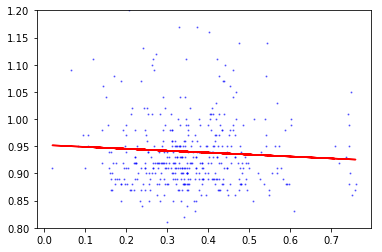

                adjusted_MLR  market_avg_pen
adjusted_MLR        1.000000       -0.058534
market_avg_pen     -0.058534        1.000000


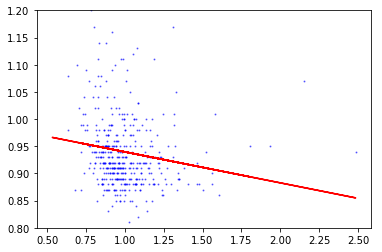

              adjusted_MLR  risk_score
adjusted_MLR      1.000000   -0.146027
risk_score       -0.146027    1.000000


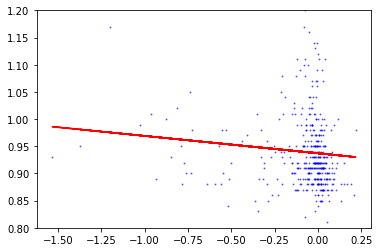

                 adjusted_MLR  risk_score_diff
adjusted_MLR         1.000000        -0.090442
risk_score_diff     -0.090442         1.000000


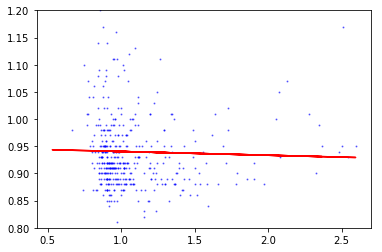

                   adjusted_MLR  market_risk_score
adjusted_MLR           1.000000          -0.028485
market_risk_score     -0.028485           1.000000


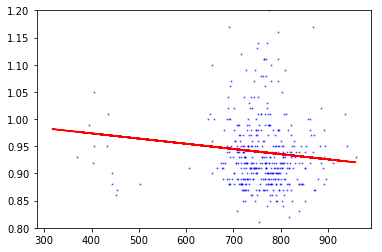

                    adjusted_MLR  market_avg_payment
adjusted_MLR             1.00000            -0.10077
market_avg_payment      -0.10077             1.00000


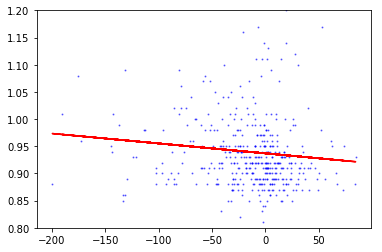

              adjusted_MLR  payment_diff
adjusted_MLR      1.000000     -0.100239
payment_diff     -0.100239      1.000000
                    contract_year  adjusted_MLR  risk_score  avg_payment  \
contract_year                 NaN           NaN         NaN          NaN   
adjusted_MLR                  NaN      1.000000   -0.146027    -0.144339   
risk_score                    NaN     -0.146027    1.000000    -0.031153   
avg_payment                   NaN     -0.144339   -0.031153     1.000000   
total_enrollment              NaN     -0.019495    0.016485     0.073043   
market_risk_score             NaN     -0.028485    0.737005     0.043455   
market_avg_payment            NaN     -0.100770   -0.024937     0.873356   
market_avg_pen                NaN     -0.058534    0.254847    -0.428616   
risk_score_diff               NaN     -0.090442   -0.170698    -0.091503   
payment_diff                  NaN     -0.100239   -0.015525     0.358682   

                    total_enrollment  ma

In [6]:
print df_MLR.describe()

#Graph Penetration Rate x MLR             
x = df_MLR['market_avg_pen']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_avg_pen']].corr()

#Graph Risk Score x MLR             
x = df_MLR['risk_score']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'risk_score']].corr()
#Somewhat of a correlation, let me try to look at the difference between the risk score and market avg
df_MLR['risk_score_diff'] = df_MLR['risk_score'] - df_MLR['market_risk_score']

#Graph Risk Score Diff x MLR             
x = df_MLR['risk_score_diff']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'risk_score_diff']].corr()

#Graph Market Risk Score x MLR             
x = df_MLR['market_risk_score']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_risk_score']].corr()

#Graph Market Avg. Payment x MLR  
x = df_MLR['market_avg_payment']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'market_avg_payment']].corr()

#Somewhat of a correlation, let me try to look at the difference between the market avg pymt and market avg
df_MLR['payment_diff'] = df_MLR['avg_payment'] - df_MLR['market_avg_payment']

#Graph Payment Diff x MLR  
x = df_MLR['payment_diff']
y = df_MLR['adjusted_MLR']
fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y, s=1, c='blue', alpha=0.5)
plt.ylim([0.80,1.20])
plt.show()

print df_MLR[['adjusted_MLR', 'payment_diff']].corr()

#Look at Correlation Matrix to help in feature selection
print df_MLR.corr()

Biggest Takeaway:<br>
MLR seems to have a fairly wide distribution.  However, on the surface, no factor seems to have significant correlation on its own.
<br> <br>
Next:<br>
Below I set up a random forest and a very crude linear regression.  Neither of them perform particularly well, but just wanted to start testing things out.  Stay tuned after the models to see what I plan to do next.

Section 4 - Crude Model Testing

In [9]:
from sklearn.ensemble import RandomForestClassifier
df_MLR['is_profitable'] = df_MLR['adjusted_MLR'].apply(lambda x: 1 if x < 1 else 0)
predictors = ['risk_score', 'avg_payment', 'market_avg_pen', 'payment_diff']
X = df_MLR[predictors]
y= df_MLR['is_profitable']
model = RandomForestClassifier(n_estimators = 20)   
model.fit(X, y)
features = predictors
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

print features_df.head()

from sklearn import cross_validation
kfold = cross_validation.KFold(len(X), n_folds=10)
scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='roc_auc')
print 'Average AUC %f' % scores.mean()




from sklearn.linear_model import LinearRegression
predictors = ['avg_payment', 'risk_score_diff', 'market_avg_pen']
X = df_MLR[predictors]
y= df_MLR['adjusted_MLR']
model = LinearRegression()
model.fit(X, y)

scores = cross_validation.cross_val_score(model, X, y, cv=kfold,scoring='neg_mean_squared_error')
print 'Average MSE %f' % scores.mean()

         Features  Importance Score
0      risk_score          0.289430
3    payment_diff          0.242482
2  market_avg_pen          0.241629
1     avg_payment          0.226459
Average AUC 0.604870
Average MSE -0.005626


Next Steps:
1. Create dummy variables for incorporation based on plan characteristics such as plan network type, organization type and plan size
2. Incorporate plan quality file.  I originally intended to include this, but thought I wasn't going to be able to make it work.  I discussed with a coworker today and determined a plan to incorporate, but didn't have time to do so before this first deadline.  Happy to share when incorporated.